In [1]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
include_top=False,
input_shape=(150, 150, 3))

2024-04-09 14:28:45.836375: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-09 14:28:45.860203: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 14:28:45.860230: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 14:28:45.860234: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-09 14:28:45.864021: I tensorflow/core/platform/cpu_feature_g

In [2]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
base_dir = '/home/shidaohg/WorkPlace/data/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0

    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.


2024-04-09 14:28:53.547427: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-04-09 14:28:53.605831: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-09 14:28:53.823145: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 828.81MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-09 14:28:53.823187: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-09 14:28:53.905196: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to alloca

1/1 [==============================] - 0s 12ms/step


2024-04-09 14:28:54.271824: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.23GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-09 14:28:54.271853: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-09 14:28:54.301985: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1/1 [==============================] - 0s 12ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 11ms/step
Found 1000 images belonging to 2 classes.
1/1 [==============================] - 0s 12ms/step


In [3]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 16812353 (64.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [5]:
print('This is the number of trainable weights ''before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [6]:
conv_base.trainable = False
print('This is the number of trainable weights ''before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 4


In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
            train_dir,
            target_size=(150, 150),
            batch_size=20,
            class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
            validation_dir,
            target_size=(150, 150),
            batch_size=20,
            class_mode='binary')

model.compile(loss='binary_crossentropy',
            optimizer=optimizers.RMSprop(lr=2e-5),
            metrics=['acc'])

history = model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Epoch 1/30


/tmp/ipykernel_14793/2662949525.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


100/100 [==============================] - 7s 64ms/step - loss: 0.2683 - acc: 0.8795 - val_loss: 0.3106 - val_acc: 0.8860
Epoch 2/30
100/100 [==============================] - 6s 63ms/step - loss: 0.2478 - acc: 0.8975 - val_loss: 0.2721 - val_acc: 0.8900
Epoch 3/30
100/100 [==============================] - 6s 63ms/step - loss: 0.2562 - acc: 0.8885 - val_loss: 0.2610 - val_acc: 0.8910
Epoch 4/30
100/100 [==============================] - 6s 63ms/step - loss: 0.2495 - acc: 0.8895 - val_loss: 0.2823 - val_acc: 0.8810
Epoch 5/30
100/100 [==============================] - 6s 63ms/step - loss: 0.2455 - acc: 0.8895 - val_loss: 0.3128 - val_acc: 0.8720
Epoch 6/30
100/100 [==============================] - 6s 63ms/step - loss: 0.2420 - acc: 0.8965 - val_loss: 0.2712 - val_acc: 0.9020
Epoch 7/30
100/100 [==============================] - 6s 63ms/step - loss: 0.2446 - acc: 0.9015 - val_loss: 0.2653 - val_acc: 0.8930
Epoch 8/30
100/100 [==============================] - 6s 63ms/step - loss: 0.238

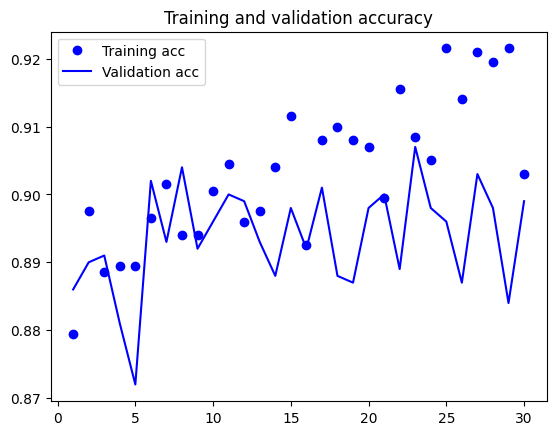

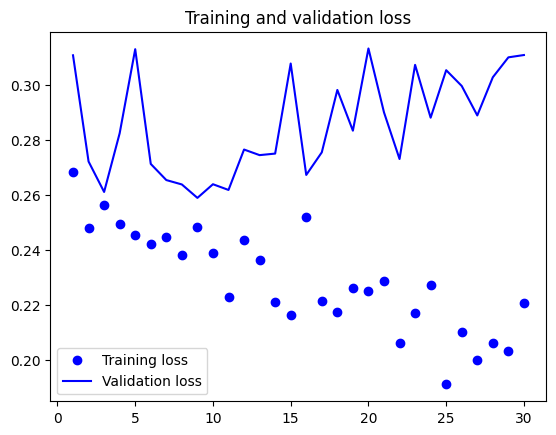

In [10]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [11]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [12]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [13]:
model.compile(loss='binary_crossentropy',
            optimizer=optimizers.RMSprop(learning_rate=1e-5),
            metrics=['acc'])

history = model.fit(
        train_generator,
        steps_per_epoch=100,
        epochs=100,
        validation_data=validation_generator,
        validation_steps=50)

Epoch 1/100


/tmp/ipykernel_14793/374038305.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


100/100 [==============================] - 7s 65ms/step - loss: 30.2590 - acc: 0.5070 - val_loss: 0.6923 - val_acc: 0.5070
Epoch 2/100
100/100 [==============================] - 6s 64ms/step - loss: 1.7954 - acc: 0.5390 - val_loss: 0.7273 - val_acc: 0.5060
Epoch 3/100
100/100 [==============================] - 6s 64ms/step - loss: 0.6880 - acc: 0.6170 - val_loss: 0.5349 - val_acc: 0.7900
Epoch 4/100
100/100 [==============================] - 7s 67ms/step - loss: 0.7126 - acc: 0.7570 - val_loss: 0.3941 - val_acc: 0.8360
Epoch 5/100
100/100 [==============================] - 7s 71ms/step - loss: 0.4240 - acc: 0.8270 - val_loss: 0.2763 - val_acc: 0.8930
Epoch 6/100
100/100 [==============================] - 7s 65ms/step - loss: 0.5065 - acc: 0.8330 - val_loss: 0.2117 - val_acc: 0.9190
Epoch 7/100
100/100 [==============================] - 6s 64ms/step - loss: 0.3238 - acc: 0.8655 - val_loss: 0.3865 - val_acc: 0.8180
Epoch 8/100
100/100 [==============================] - 6s 65ms/step - los

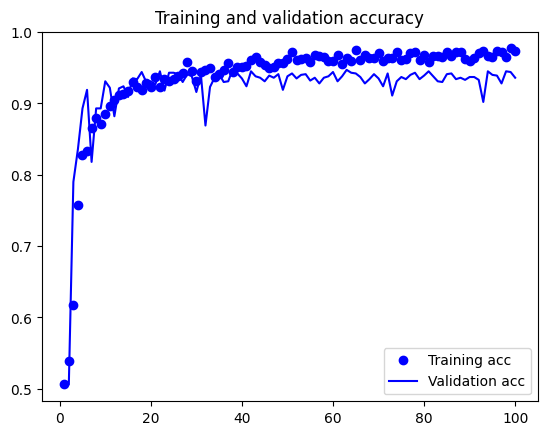

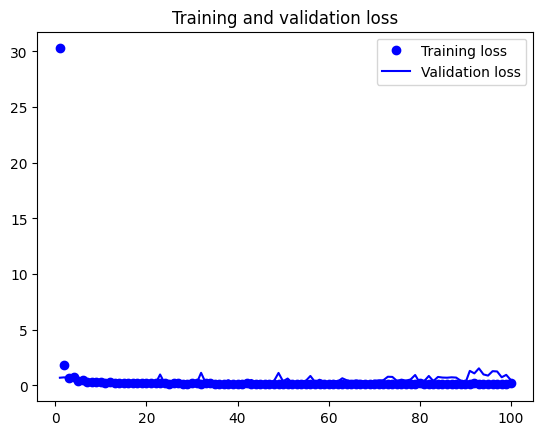

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

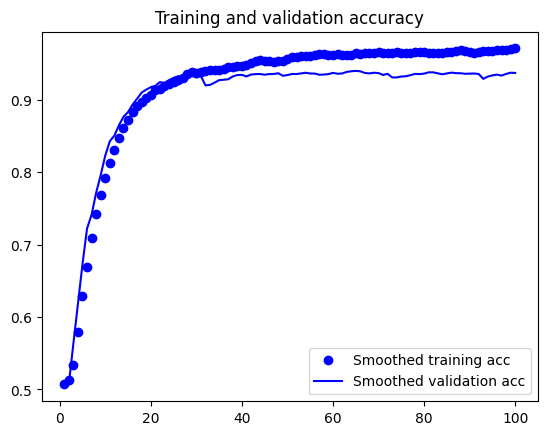

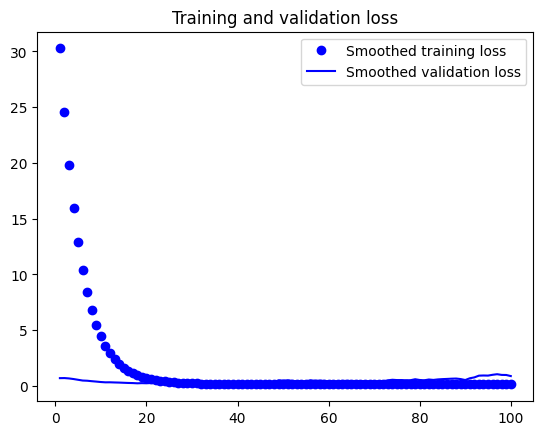

In [21]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,
        smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
        smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [22]:
max(val_acc)

0.9480000138282776

In [24]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')
test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 2s 30ms/step - loss: 1.0276 - acc: 0.9260
test acc: 0.9259999990463257
